In [1]:
import pandas as pd
import fnmatch
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import pickle
import time
import keras
from sklearn.model_selection import train_test_split
import keras_metrics
import matplotlib.pyplot as plt


In [11]:
#AlexNet Architecture for pH estimation
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(300,300,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 36, 36, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 384)      

In [3]:
Lab_tested_data = pd.read_csv('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Final-Year-Project-Soil-Analysis-using-machine-learning\\Lab Results\\Soil_Lab_Results - Sheet1.csv')

In [4]:
print(len(Lab_tested_data))
#Getting sample id for each image with its lab value
Sample_ID = Lab_tested_data.iloc[:,0]
pH_Value = Lab_tested_data.iloc[:,2]

1572


In [5]:
def load_images_from_folder(folder):
    Labels = []
    image_counter = 0
    for filename in os.listdir(folder):
        x = filename.split("_")
        id = float(x[0])
        img = cv2.imread(os.path.join(folder,filename))
        width = 1000
        height = 1000
        dim = (width, height)
        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img = img[500:800,500:800] #Resizing the image
        kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
        img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel.
        Result = Sample_ID.isin([id])
        Result = Sample_ID[Result];
        if len(Result) >= 1:
            print(image_counter)
            image_counter = image_counter + 1
            if len(Result) == 2:  
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                Id_2_index = Result[1]
                #Average of both inner and surface image soil result 
                pH_lab_value = (pH_Value[Id_2_index] + pH_Value[Id_2_index]) / 2
                #Assigning classs number 0,1,2,3,4
                if pH_lab_value < 7.0:
                    Labels.append([filename,img,0])
                elif pH_lab_value >= 7.0 and pH_lab_value <= 7.5:
                    Labels.append([filename,img,1])
                elif pH_lab_value > 7.5 and pH_lab_value <= 8.0:
                    Labels.append([filename,img,2])
                elif pH_lab_value > 8.0 and pH_lab_value <= 8.5:
                    Labels.append([filename,img,3])
                elif pH_lab_value > 8.5:
                    Labels.append([filename,img,4])
            elif len(Result==1):
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                pH_lab_value = pH_Value[Id_1_index]
                #Assigning classs number 0,1,2,3,4
                if pH_lab_value < 7.0:
                    Labels.append([filename,img,0])
                elif pH_lab_value >= 7.0 and pH_lab_value <= 7.5:
                    Labels.append([filename,img,1])
                elif pH_lab_value > 7.5 and pH_lab_value <= 8.0:
                    Labels.append([filename,img,2])
                elif pH_lab_value > 8.0 and pH_lab_value <= 8.5:
                    Labels.append([filename,img,3])
                elif pH_lab_value > 8.5:
                    Labels.append([filename,img,4])
        else:
            print(len(Result))
            print("Hi i am here for testing")
            continue
    return Labels

In [6]:
#loading dataset 
dataset = load_images_from_folder('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Dataset RGB\\Training_data')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
#Preparing data for model
X = []
Y = []
for data in dataset:
    X.append(data[1])
    Y.append(data[2])
print(Y)
print(len(X))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [8]:
img_size = 300
X = np.array(X).reshape(-1, img_size, img_size, 3)
print(X[0].shape)
Y = to_categorical(Y)
print(Y[100])
print(X.shape)

(300, 300, 3)
[0. 0. 1. 0.]
(1064, 300, 300, 3)


In [9]:
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X, Y)
print(Y[522])

(1064, 300, 300, 3)
[0. 0. 0. 1.]


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.3)

Epoch 1/500


C:\Users\Mahmood Yousaf\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


18/18 [==============================] - 10s 337ms/step - loss: 36.5235 - accuracy: 0.3387 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 28078.8633 - val_accuracy: 0.0708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/500
18/18 [==============================] - 3s 179ms/step - loss: 18.4261 - accuracy: 0.2814 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 519.6556 - val_accuracy: 0.0625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/500
18/18 [==============================] - 3s 179ms/step - loss: 10.8517 - accuracy: 0.4552 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 120.6655 - val_accuracy: 0.8583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/500
18/18 [==============================] - 3s 178ms/step - loss: 8.4673 - accuracy: 0.6882 - precision: 0.0000e+00 - 

18/18 [==============================] - 3s 184ms/step - loss: 1.3900 - accuracy: 0.8029 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 8.9027 - val_accuracy: 0.4750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 21/500
18/18 [==============================] - 3s 181ms/step - loss: 1.4622 - accuracy: 0.7545 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 12.2176 - val_accuracy: 0.0833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 22/500
18/18 [==============================] - 3s 179ms/step - loss: 0.8930 - accuracy: 0.8100 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 5.2261 - val_accuracy: 0.2583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 23/500
18/18 [==============================] - 3s 179ms/step - loss: 1.0641 - accuracy: 0.8136 - precision: 0.0000e+00 - recall: 

18/18 [==============================] - 3s 184ms/step - loss: 0.7470 - accuracy: 0.8477 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.2957 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 49/500
18/18 [==============================] - 3s 184ms/step - loss: 0.5639 - accuracy: 0.8728 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.9625 - val_accuracy: 0.8417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 50/500
18/18 [==============================] - 3s 181ms/step - loss: 0.4206 - accuracy: 0.8656 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.1210 - val_accuracy: 0.7958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 51/500
18/18 [==============================] - 3s 183ms/step - loss: 0.5859 - accuracy: 0.8674 - precision: 0.0000e+00 - recall: 0

18/18 [==============================] - 3s 181ms/step - loss: 0.7148 - accuracy: 0.8853 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.6046 - val_accuracy: 0.6875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 77/500
18/18 [==============================] - 3s 180ms/step - loss: 0.7085 - accuracy: 0.8799 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.6344 - val_accuracy: 0.8167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 78/500
18/18 [==============================] - 3s 180ms/step - loss: 0.8013 - accuracy: 0.8620 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.6352 - val_accuracy: 0.7042 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 79/500
18/18 [==============================] - 3s 181ms/step - loss: 0.4133 - accuracy: 0.8638 - precision: 0.0000e+00 - recall: 0

18/18 [==============================] - 3s 181ms/step - loss: 0.2805 - accuracy: 0.9480 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 3.8907 - val_accuracy: 0.8667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 105/500
18/18 [==============================] - 3s 181ms/step - loss: 0.1924 - accuracy: 0.9427 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 5.5347 - val_accuracy: 0.8458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 106/500
18/18 [==============================] - 3s 181ms/step - loss: 0.1988 - accuracy: 0.9337 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 4.0827 - val_accuracy: 0.8417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 107/500
18/18 [==============================] - 3s 181ms/step - loss: 0.3347 - accuracy: 0.9606 - precision: 0.0000e+00 - recall

Epoch 132/500
18/18 [==============================] - 3s 181ms/step - loss: 2.3374 - accuracy: 0.8459 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 17.0777 - val_accuracy: 0.8583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 133/500
18/18 [==============================] - 3s 180ms/step - loss: 1.3328 - accuracy: 0.8728 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 9.5100 - val_accuracy: 0.8583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 134/500
18/18 [==============================] - 3s 181ms/step - loss: 0.7723 - accuracy: 0.9140 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 8.1818 - val_accuracy: 0.7875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 135/500
18/18 [==============================] - 3s 181ms/step - loss: 0.7250 - accuracy: 0.9158 - precision: 0.00

Epoch 160/500
18/18 [==============================] - 3s 181ms/step - loss: 0.2318 - accuracy: 0.9713 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 10.1935 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 161/500
18/18 [==============================] - 3s 181ms/step - loss: 0.1638 - accuracy: 0.9606 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 11.0329 - val_accuracy: 0.8208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 162/500
18/18 [==============================] - 3s 181ms/step - loss: 0.3110 - accuracy: 0.9606 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 6.3851 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 163/500
18/18 [==============================] - 3s 180ms/step - loss: 0.2557 - accuracy: 0.9677 - precision: 0.0

Epoch 188/500
18/18 [==============================] - 3s 180ms/step - loss: 0.1252 - accuracy: 0.9624 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 7.5959 - val_accuracy: 0.7625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 189/500
18/18 [==============================] - 3s 180ms/step - loss: 0.5734 - accuracy: 0.9373 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 6.5818 - val_accuracy: 0.7583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 190/500
18/18 [==============================] - 3s 180ms/step - loss: 0.5044 - accuracy: 0.8835 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 13.9588 - val_accuracy: 0.8292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 191/500
18/18 [==============================] - 3s 180ms/step - loss: 0.8891 - accuracy: 0.9516 - precision: 0.00

Epoch 216/500
18/18 [==============================] - 3s 180ms/step - loss: 0.0444 - accuracy: 0.9839 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 12.0663 - val_accuracy: 0.8500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 217/500
18/18 [==============================] - 3s 180ms/step - loss: 0.1008 - accuracy: 0.9821 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 14.2105 - val_accuracy: 0.8542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 218/500
18/18 [==============================] - 3s 180ms/step - loss: 0.2512 - accuracy: 0.9659 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 11.2228 - val_accuracy: 0.8542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 219/500
18/18 [==============================] - 3s 180ms/step - loss: 0.0972 - accuracy: 0.9821 - precision: 0.

Epoch 244/500
18/18 [==============================] - 3s 180ms/step - loss: 0.5817 - accuracy: 0.9785 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 17.1064 - val_accuracy: 0.8667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 245/500
18/18 [==============================] - 3s 180ms/step - loss: 0.4626 - accuracy: 0.9875 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 19.4838 - val_accuracy: 0.8417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 246/500
18/18 [==============================] - 3s 180ms/step - loss: 1.5205 - accuracy: 0.9767 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 25.4091 - val_accuracy: 0.8167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 247/500
18/18 [==============================] - 3s 180ms/step - loss: 0.7853 - accuracy: 0.9749 - precision: 0.

Epoch 272/500
18/18 [==============================] - 3s 181ms/step - loss: 0.1566 - accuracy: 0.9659 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 26.2345 - val_accuracy: 0.7292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 273/500
18/18 [==============================] - 3s 180ms/step - loss: 0.1799 - accuracy: 0.9659 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 23.8562 - val_accuracy: 0.7875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 274/500
18/18 [==============================] - 3s 180ms/step - loss: 0.4211 - accuracy: 0.9875 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 26.6935 - val_accuracy: 0.8250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 275/500
18/18 [==============================] - 3s 180ms/step - loss: 0.1354 - accuracy: 0.9946 - precision: 0.

Epoch 300/500
18/18 [==============================] - 3s 181ms/step - loss: 0.6741 - accuracy: 0.9892 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 26.8360 - val_accuracy: 0.8542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 301/500
18/18 [==============================] - 3s 181ms/step - loss: 0.1410 - accuracy: 0.9875 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 27.6767 - val_accuracy: 0.8167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 302/500
18/18 [==============================] - 3s 180ms/step - loss: 2.1364e-10 - accuracy: 0.9839 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 28.8080 - val_accuracy: 0.8458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 303/500
18/18 [==============================] - 3s 181ms/step - loss: 0.2605 - accuracy: 0.9857 - precision

Epoch 328/500
18/18 [==============================] - 3s 180ms/step - loss: 0.9717 - accuracy: 0.9964 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 44.3338 - val_accuracy: 0.7333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 329/500
18/18 [==============================] - 3s 180ms/step - loss: 1.9663 - accuracy: 0.9910 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 49.3700 - val_accuracy: 0.7000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 330/500
18/18 [==============================] - 3s 180ms/step - loss: 0.8164 - accuracy: 0.9892 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 37.0607 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 331/500
18/18 [==============================] - 3s 181ms/step - loss: 2.9604 - accuracy: 0.9875 - precision: 0.

Epoch 356/500
18/18 [==============================] - 3s 180ms/step - loss: 0.7305 - accuracy: 0.9910 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 42.6985 - val_accuracy: 0.8583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 357/500
18/18 [==============================] - 3s 180ms/step - loss: 0.7844 - accuracy: 0.9946 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 33.8072 - val_accuracy: 0.8167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 358/500
18/18 [==============================] - 3s 180ms/step - loss: 0.2085 - accuracy: 0.9659 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 37.0162 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 359/500
18/18 [==============================] - 3s 180ms/step - loss: 0.6031 - accuracy: 0.9964 - precision: 0.

Epoch 384/500
18/18 [==============================] - 3s 180ms/step - loss: 0.4250 - accuracy: 0.9964 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 48.0399 - val_accuracy: 0.8792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 385/500
18/18 [==============================] - 3s 180ms/step - loss: 0.7072 - accuracy: 0.9749 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 93.1244 - val_accuracy: 0.8542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 386/500
18/18 [==============================] - 3s 180ms/step - loss: 2.4859 - accuracy: 0.9606 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 41.2398 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 387/500
18/18 [==============================] - 3s 181ms/step - loss: 0.5663 - accuracy: 0.9498 - precision: 0.

Epoch 412/500
18/18 [==============================] - 3s 181ms/step - loss: 0.0224 - accuracy: 0.9928 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 74.2210 - val_accuracy: 0.8208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 413/500
18/18 [==============================] - 3s 181ms/step - loss: 0.7883 - accuracy: 0.9928 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 129.9905 - val_accuracy: 0.8667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 414/500
18/18 [==============================] - 3s 180ms/step - loss: 0.0664 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 145.1699 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 415/500
18/18 [==============================] - 3s 184ms/step - loss: 0.4042 - accuracy: 0.9892 - precision: 

Epoch 440/500
18/18 [==============================] - 3s 180ms/step - loss: 0.0430 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 61.4299 - val_accuracy: 0.8667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 441/500
18/18 [==============================] - 3s 179ms/step - loss: 0.0854 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 62.1456 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 442/500
18/18 [==============================] - 3s 181ms/step - loss: 0.7816 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 87.0564 - val_accuracy: 0.8708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 443/500
18/18 [==============================] - 3s 179ms/step - loss: 0.1287 - accuracy: 0.9946 - precision: 0.

Epoch 468/500
18/18 [==============================] - 3s 180ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 87.1247 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 469/500
18/18 [==============================] - 3s 179ms/step - loss: 0.5979 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 77.5282 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 470/500
18/18 [==============================] - 3s 179ms/step - loss: 0.0000e+00 - accuracy: 0.9928 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 95.1645 - val_accuracy: 0.8667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 471/500
18/18 [==============================] - 3s 179ms/step - loss: 0.0000e+00 - accuracy: 0.9964 - p

Epoch 496/500
18/18 [==============================] - 3s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 109.6751 - val_accuracy: 0.8792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 497/500
18/18 [==============================] - 3s 184ms/step - loss: 0.2823 - accuracy: 0.9946 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 90.6681 - val_accuracy: 0.8792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 498/500
18/18 [==============================] - 3s 187ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 63.9934 - val_accuracy: 0.8375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 499/500
18/18 [==============================] - 3s 182ms/step - loss: 0.2567 - accuracy: 0.9982 - prec

In [13]:
model.evaluate(X_val,y_val)

9/9 [==============================] - 1s 144ms/step - loss: 83.3625 - accuracy: 0.8496 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00


[83.36250305175781, 0.8496240377426147, 0.0, 0.0, 0.0]

In [19]:
y_val[100]

array([0., 0., 1., 0.], dtype=float32)

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


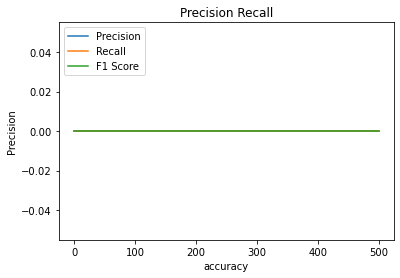

In [15]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlabel('accuracy')

plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()